# Introduction to Raster Data Analysis in Python

## 1. Setting the scene  

### 1.1. Import required libraries

In [1]:
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations

### 1.2. Define paths to datasets

In [5]:
m_root=r"C:/Users/VICTUS/Documents/MG(2)/programacion_sig/notebook/Workshop/PS/data"
aoi=m_root+r"/jerico.gpkg" # Path to the vector file that contains the AOI
dem_path=m_root+"/dem_aoi.tif" # Path where the downloaded DEM will be stored

## 2. Reading a raster file using rasterio

In [6]:
src_dem = rasterio.open(dem_path)
src_dem 

<open DatasetReader name='C:/Users/VICTUS/Documents/MG(2)/programacion_sig/notebook/Workshop/PS/data/dem_aoi.tif' mode='r'>

## 3. Explore the raster data  

### 3.1. Quick raster visualisation using `rasterio.plot.show()`

Before diving into detailed statistics or custom plots, it is often useful to quickly visualise the raster to confirm that it loads correctly and has valid data.  

The function rasterio.plot.show() provides a simple and effective way to display a raster image. By default, it shows the first band using a greyscale colour scheme. This is a useful starting point to check the spatial extent, contrast, and general appearance of the raster.  

In the example below, we assume the raster has already been opened with rasterio.open(...) and stored in the variable src_dem.  

This approach is convenient for quick checks and initial exploration.

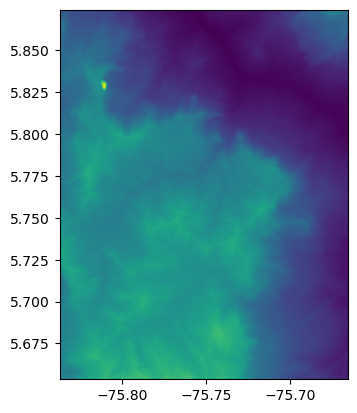

<Axes: >

In [7]:
rasterio.plot.show(src_dem)

### 3.2 Reading raster values from the file

In [8]:
band1 = src_dem.read(1)  # Read the first layer as a 2D numpy array (rows x columns)

# Check the shape and type of the result
print("Array shape (rows, cols):", band1.shape)
print("Array data type:", band1.dtype)
print("Array ", band1)

Array shape (rows, cols): (819, 639)
Array data type: int16
Array  [[1350 1352 1357 ... 1631 1617 1613]
 [1361 1364 1366 ... 1627 1615 1610]
 [1373 1372 1377 ... 1623 1616 1609]
 ...
 [1834 1841 1845 ...  802  812  815]
 [1817 1820 1820 ...  814  826  832]
 [1801 1801 1801 ...  824  836  840]]


### 3.3. Raster subsetting

Once raster data has been loaded into a NumPy array using .read(), we can access individual pixel values or subsets of the raster using standard NumPy indexing.  

- For single-band rasters, read(1) returns a 2D array in (rows, columns) format.  
- To access the value at row 2, column 3, we use: elev[1, 2]  
- You can also overwrite values, for example: elev[1, 2] = 0  
- To modify multiple cells: elev[0, 0:3] = 0  

If you use .read() without an index, it returns a 3D array of shape (bands, rows, columns), even for single-band rasters. To access a cell in this case, use elev3d[0, row, column].

In [9]:
# Read the first band (2D array)
elev = src_dem.read(1)
print(elev[1, 2])  # Access pixel value at row 2, column 3

# Modify a pixel value
elev[1, 2] = 0
print(elev[1, 2])  # Confirm the change

# Modify a range of pixels
elev[0, 0:3] = 0
print(elev[0, :6])  # Print first six values in row 1

# Read as a 3D array (even for one-band raster)
elev3d = src_dem.read()
print(elev3d.shape)  # (bands, rows, columns)
print(elev3d[0, 1, 2])  # Same cell as before using 3D indexing

1366
0
[   0    0    0 1352 1357 1360]
(1, 819, 639)
1366


### 3.4. Summary statistics and visualisation

Raster dimensions (rows, cols): (819, 639)
Number of bands: 1
Coordinate reference system (CRS): EPSG:4326
Resolution (pixel size): (0.0002694945852358564, 0.0002694945852358564)
Data type: int16
Min / Max elevation: 530 / 3647


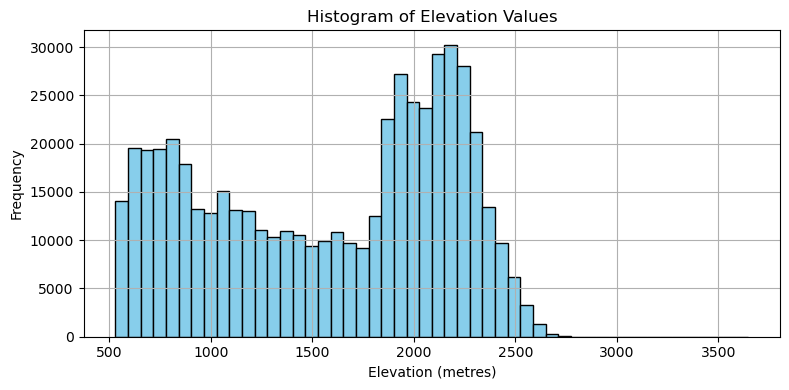

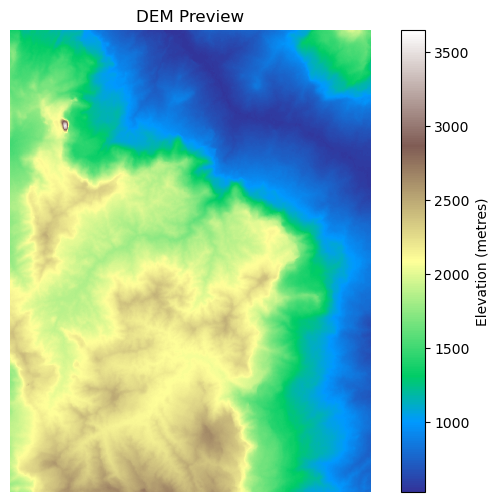

In [10]:
# Open the raster file safely using a context manager
# This ensures the file is automatically closed after the block finishes
with rasterio.open(dem_path) as src:
    
    # Read the first band of the raster (DEM values are stored in the first band)
    dem_data = src.read(1)

    # Display basic metadata about the raster ---
    print("Raster dimensions (rows, cols):", dem_data.shape)        # Size of the raster in pixels
    print("Number of bands:", src.count)                             # Number of raster bands (should be 1 for a DEM)
    print("Coordinate reference system (CRS):", src.crs)            # The spatial reference system
    print("Resolution (pixel size):", src.res)                      # Pixel resolution in spatial units (e.g. metres)
    print("Data type:", dem_data.dtype)                             # Data type of the pixel values (e.g. float32, int16)
    print("Min / Max elevation:", np.nanmin(dem_data), "/", np.nanmax(dem_data))  # Elevation range, ignoring NaNs

    #  Create a histogram to visualise the distribution of elevation values ---
    plt.figure(figsize=(8, 4))
    plt.hist(
        dem_data[~np.isnan(dem_data)].flatten(),  # Flatten the array and exclude NaN values
        bins=50,
        color='skyblue',
        edgecolor='black'
    )
    plt.title("Histogram of Elevation Values")
    plt.xlabel("Elevation (metres)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Display the DEM as an image using a colour scale ---
    plt.figure(figsize=(8, 6))
    plt.imshow(dem_data, cmap='terrain')            # Apply a terrain colourmap
    plt.colorbar(label="Elevation (metres)")        # Add a colourbar for elevation
    plt.title("DEM Preview")                        # Plot title
    plt.axis("off")                                 # Hide axis ticks and labels
    plt.show()

### 3.5. Handling Missing Data in Raster Arrays  

Sometimes, raster data may include invalid or missing values — such as areas outside the zone of interest, nodata pixels, or artefacts. These can be represented using np.nan in NumPy.  

However, integer arrays cannot store np.nan, so we must first convert them to a floating-point type. We will then demonstrate how to insert np.nan, compute statistics, and visualise the cleaned data.  

- Note: In our case, we continue working with the raster values previously stored in the variable dem_data, which was read using .read(1) from the raster file.  

- Reflect: Why is flatten() used before plotting with plt.hist()?

mask [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
Mean including NaN: nan
Mean ignoring NaN: 723.0239580961056


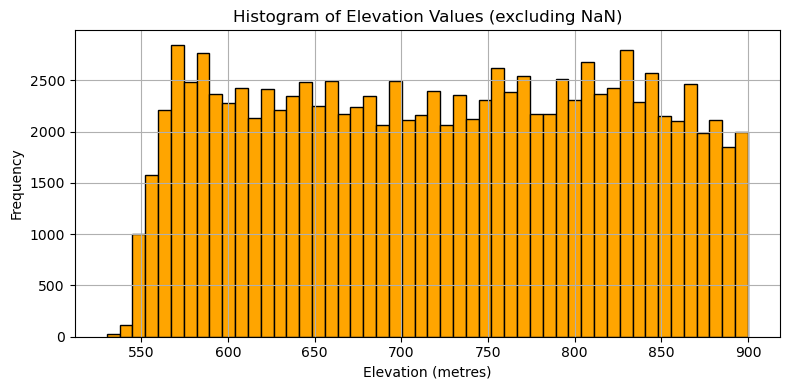

In [11]:
# Make a copy of the original raster array and convert it to float64
# This allows the use of np.nan, which is not possible with integer types
elev1 = dem_data.astype('float64')  # dem_data was previously read using .read(1)

# Create a boolean mask to identify all cells with elevation greater than 900 metres
# These will be treated as invalid and replaced with np.nan
mask = (elev1 > 900)
print("mask",mask)

elev1[mask] = np.nan  # Replace those cells with NaN (missing values)

# Calculate the mean elevation using both regular and NaN-aware functions
# The first will return NaN due to the presence of missing values
# The second will correctly ignore them
print("Mean including NaN:", np.mean(elev1))
print("Mean ignoring NaN:", np.nanmean(elev1))

# Visualise the cleaned elevation values using a histogram
# NaN values are excluded using a mask
plt.figure(figsize=(8, 4))
plt.hist(elev1[~np.isnan(elev1)].flatten(), bins=50, color='orange', edgecolor='black')
plt.title("Histogram of Elevation Values (excluding NaN)")
plt.xlabel("Elevation (metres)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

### ✏️ Now it’s your turn!  

Use the array elev1, which contains some missing values (represented as np.nan), to compute additional summary statistics using NumPy.  

- Calculate the maximum and minimum elevation values while ignoring NaNs.  
- Calculate the standard deviation of the valid elevation values.  
- Count how many values are missing using a boolean mask and .sum().  
- Optionally: Calculate the range (max - min) of valid elevation values.  

Remember: Use np.nanmax(), np.nanmin(), np.nanstd(), and boolean logic such as np.isnan(elev1).sum() to help with this

### 3.6. Exploring raster metadata with `.meta`  

When working with raster data in Python using rasterio, each raster file contains the metadata that describes its structure and spatial properties. The .meta attribute provides a dictionary summarising key metadata fields of the raster file. src_dem.meta returns a dictionary with key properties of the raster dataset.

In [12]:
src_dem.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 639,
 'height': 819,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.0002694945852358564, 0.0, -75.8375172547928,
        0.0, -0.0002694945852358564, 5.874307400949014)}

**Understanding transform** 

To accurately place a raster in geographic space, it is not enough to know just the Coordinate Reference System (CRS). We must also define i) the origin of the raster: the coordinates of the upper-left corner (x_min, y_max), and ii) the pixel resolution: width and height of each cell (delta_x, delta_y).  

In rasterio, these values are stored using an affine transformation matrix.  

Note that, by convention, the origin of the raster y-axis is set to the maximum value (y_max) rather than the minimum. As a result, the y-axis resolution (delta_y) is negative. It reflects the way raster images are stored: the origin is in the top-left corner, and moving downward along the rows corresponds to decreasing y-values.  

### ✏️ Now it’s your turn – Understanding raster metadata  

Explain in your own words what the other elements of the raster metadata mean